kdv eqn:
$$u_t +uu_x +u_{xxx} = 0$$

where u_x = first derivative of u wrt x

## Variables  

### u_only_mat_reshaped (size: 8 x 10 x 400) 
- only contains the u variable
- First dimension is the number of cases (8)
- The second dimension is the number of time snapshots (10)
- The third dimension corresponds to the number of space points (400)

### u_mat (size: 32000 × 5)  
- Each row corresponds to a point in space and time for a given case.  
- Each column contains one of the following values:  
  1. u — solution value  
  2. ux — first spatial derivative (∂u/∂x)  
  3. uxx — second spatial derivative (∂²u/∂x²)  
  4. uxxx — third spatial derivative (∂³u/∂x³)  
  5. uxxxx — fourth spatial derivative (∂⁴u/∂x⁴)  

#### Structure
- Data is organised sequentially over space, time, and cases.  
- Dimensions:  
  - Space (N): 400 points  
  - Time (Nt): 10 snapshots  
  - Cases (N_case): 8 independent cases  
- Overall shape: 400 × 10 × 8 = 32000 rows  

Row ordering follows:  

Case 1
u(x0,t0)   ux(x0,t0)   uxx(x0,t0)   uxxx(x0,t0)   uxxxx(x0,t0)
u(x1,t0)   ux(x1,t0)   uxx(x1,t0)   uxxx(x1,t0)   uxxxx(x1,t0)
...
u(x399,t0) ...
u(x0,t1)   ...
...
u(x399,t9) ...
Case 2
...
Case 8
...

---

### u_tar (size: 32000 × 1)  
- Contains the time derivative:  
  - ut — ∂u/∂t  
- Follows the same row ordering as u_mat.  

---

✅ In short:  
- u_mat provides the state (u and spatial derivatives).  
- u_tar provides the target (time derivative).  
- Together, they represent spatio-temporal samples from 8 cases of the KdV equation.  

---

## Tensor Reshaping Illustration

Think of the data as a 3D tensor:

    [Space = 400] × [Time = 10] × [Cases = 8] = 32000 samples

Each row in u_mat and u_tar corresponds to one slice of this tensor, flattened into a 2D matrix.


In [1]:
import pysr
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor, TemplateExpressionSpec, TensorBoardLoggerSpec
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import pysindy as ps
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Set up default parameters we'll reuse
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [39]:
import pysr
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor, TemplateExpressionSpec, TensorBoardLoggerSpec
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import pysindy as ps
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Set up default parameters we'll reuse
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)
KdV_data = loadmat('./kdv_data_for_workshop.mat')
data = KdV_data['u_mat'][:,0]
u_reshape = data.reshape(8,10,400)
target = KdV_data['u_tar']
var_names = ['u']
u_reshape.shape, target.shape
u_new = KdV_data['u_only_mat_reshaped']
u_new.shape
#u_shape = cases x time x space
# Extract spatial coordinates
x = KdV_data['x_vec'].flatten()
t = KdV_data['t_vec'].flatten()
x.shape,  t.shape

# take one case
case1 = u_reshape[0,:,:]
case1 = u_new[0,:,:]
case1=case1.T # shape is now space x time as in tutorial
case1=case1.reshape(400,10,1)
case1udot = ps.FiniteDifference(axis=1, order=4)._differentiate(case1, t)
case1.shape, case1udot.shape

pde_lib = ps.PDELibrary(
    function_library = ps.PolynomialLibrary(degree=1, include_bias=False),
    derivative_order = 4,
    spatial_grid = x
)
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)

method = ps.FiniteDifference(axis=1, order=2)
model = ps.SINDy(feature_library=pde_lib,optimizer=optimizer, differentiation_method=method)
model.fit(x = case1,x_dot = case1udot, t=t, feature_names=["u"])

# print library
print("PDE SINDy library: ")
print(pde_lib.get_feature_names(["u"]))

# print identified PDE
print("Identified PDE: ")
model.print()


PDE SINDy library: 
['u', 'u_1', 'u_11', 'u_111', 'u_1111', 'uu_1', 'uu_11', 'uu_111', 'uu_1111']
Identified PDE: 
(u)' = 41.637 u + -1495.547 u_1 + -82.597 u_11 + 3.203 u_111 + -0.301 u_1111 + 6.721 uu_1 + 0.038 uu_11 + 0.010 uu_111


In [2]:
KdV_data = loadmat('./kdv_data_for_workshop.mat')


In [4]:
KdV_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'N', 'N_case', 'Nt', 't_vec', 'u_mat', 'u_only_mat', 'u_only_mat_reshaped', 'u_tar', 'x_vec'])

# first task , have u, u_t, u_x,u_xx,...

In [13]:
target = KdV_data['u_tar'].flatten()
data = KdV_data['u_mat']

In [16]:
target.shape, data.shape

((32000,), (32000, 5))

In [11]:
print(KdV_data['u_mat'].shape)
print(KdV_data['u_tar'].shape)

(32000, 5)
(32000, 1)


In [23]:
var_names = ['u', 'u_x', 'u_xx', 'u_xxx', 'u_xxxx']

In [24]:
model = PySRRegressor(
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["exp", "log", "sin", "cos", "square", "cube", "sqrt"],
    # nested_constraints={"sin": {"sin": 0, "cos": 0}, "cos": {"sin": 0, "cos": 0}},
    niterations=150,
    maxsize=22,
    variable_names=var_names,
    batching = True,
    batch_size=16,
    # turbo=True,
    populations=24,
    model_selection="best",
)

/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/Symbolic_discovery/.venv/lib/python3.12/site-packages/pysr/sr.py:1046: FutureWarning: `variable_names` is a data-dependent parameter and should be passed when fit is called. Ignoring parameter; please pass `variable_names` during the call to fit instead.
  warnings.warn(


In [26]:
model.fit(data, target, variable_names=var_names)

/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/Symbolic_discovery/.venv/lib/python3.12/site-packages/pysr/sr.py:2217: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/Symbolic_discovery/.venv/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.370e+03
Progress: 1179 / 3600 total iterations (32.750%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.328e+10  0.000e+00  y = -2.1142
2           2.328e+10  -0.000e+00  y = log(u_xxxx)
3           7.126e+08  -0.000e+00  y = u_x * -266.75
7           1.596e-04  6.235e+00  y = ((-3.0622e-06 - u) * u_x) - u_xxx
9           1.596e-04  8.941e-08  y = ((-3.1203e-06 - u) * u_x) - (u_xxx + -1.3613e-06)
11          1.596e-04  2.539e-05  y = ((-2.6315e-06 - u) * u_x) + (1.1784 - (u_xxx + 1.1785)...
                                      )
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and t

[ Info: Final population:
[ Info: Results saved to:


,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,"['exp', 'log', ...]"
,expression_spec,None
,niterations,150
,populations,24
,population_size,27
,max_evals,None
,maxsize,22
,maxdepth,None
,warmup_maxsize_by,None


  - outputs/20250922_142900_a6a5Cs/hall_of_fame.csv


In [27]:
model.equations_

,complexity,loss,equation,score,sympy_format,lambda_format
0,1,2.328078e+10,-2.1141942,0.000000e+00,-2.11419420000000,PySRFunction(X=>-2.11419420000000)
1,2,2.328076e+10,log(u_xxxx),9.879398e-07,log(u_xxxx),PySRFunction(X=>log(u_xxxx))
2,3,7.118991e+08,u_x * -268.21207,3.487446e+00,u_x*(-268.21207),PySRFunction(X=>u_x*(-268.21207))
3,6,7.115906e+08,u_x * (cos(u_x) + -267.9196),1.444806e-04,u_x*(cos(u_x) - 267.9196),PySRFunction(X=>u_x*(cos(u_x) - 267.9196))
4,7,1.595570e-04,((-2.3641226e-6 - u) * u_x) - u_xxx,2.912612e+01,u_x*(-u - 2.3641226e-6) - u_xxx,PySRFunction(X=>u_x*(-u - 2.3641226e-6) - u_xxx)
5,9,1.594715e-04,((u - u_xxx) - u) - (u_x * u),2.678757e-04,-u*u_x - u + u - u_xxx,PySRFunction(X=>-u*u_x - u + u - u_xxx)
6,11,1.594715e-04,((-6.2258914e-7 - u) * u_x) - (u + (u_xxx - u)),9.406068e-08,u_x*(-u - 6.2258914e-7) - (-u + u + u_xxx),PySRFunction(X=>u_x*(-u - 6.2258914e-7) - (-u ...
7,13,1.585618e-04,(((u_x - u_x) - u_x) * u) - (u_xxx + (u_x * -2...,2.860368e-03,u*(-u_x - u_x + u_x) - (u_x*(-2.388702e-6) + u...,PySRFunction(X=>u*(-u_x - u_x + u_x) - (u_x*(-...
8,15,1.585053e-04,((u_x - u_x) - (u * u_x)) - (u_xxx + ((2.43752...,1.781326e-04,-u*u_x - u_x + u_x - (u_xxx + (2.4375262 - u_x...,PySRFunction(X=>-u*u_x - u_x + u_x - (u_xxx + ...
9,16,1.584875e-04,((cube(0.74462295 - 0.75664324) - u) * u_x) - ...,1.126839e-04,u_x*(-u + (0.74462295 - 1*0.75664324)**3) - (u...,PySRFunction(X=>u_x*(-u + (0.74462295 - 1*0.75...


In [28]:
model.sympy()

u_x*(-u - 2.3641226e-6) - u_xxx

# second task, dont have u_x,u_xx,... need to calculate myself but will then have errors/noise from calculating the spatial derivatives

In [3]:
data = KdV_data['u_mat'][:,0]
u_reshape = data.reshape(8,10,400)
target = KdV_data['u_tar']
var_names = ['u']
u_reshape.shape, target.shape
u_new = KdV_data['u_only_mat_reshaped']
u_new.shape
#u_shape = cases x time x space

(8, 10, 400)

In [19]:
# Extract spatial coordinates
x = KdV_data['x_vec'].flatten()
t = KdV_data['t_vec'].flatten()
x.shape,  t.shape
import time


In [7]:
# take one case
case1 = u_reshape[0,:,:]
case1 = u_new[0,:,:]
case1=case1.T # shape is now space x time as in tutorial
case1=case1.reshape(400,10,1)
case1udot = ps.FiniteDifference(axis=1, order=4)._differentiate(case1, t)
case1.shape, case1udot.shape

((400, 10, 1), (400, 10, 1))

In [35]:
t

array([0.        , 0.00031837, 0.00063673, 0.0009551 , 0.00127347,
       0.00159184, 0.0019102 , 0.00222857, 0.00254694, 0.00286531])

/var/folders/fv/6lp893hd21qcv8d6dcgrwb4w0000gp/T/ipykernel_13877/3251845983.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

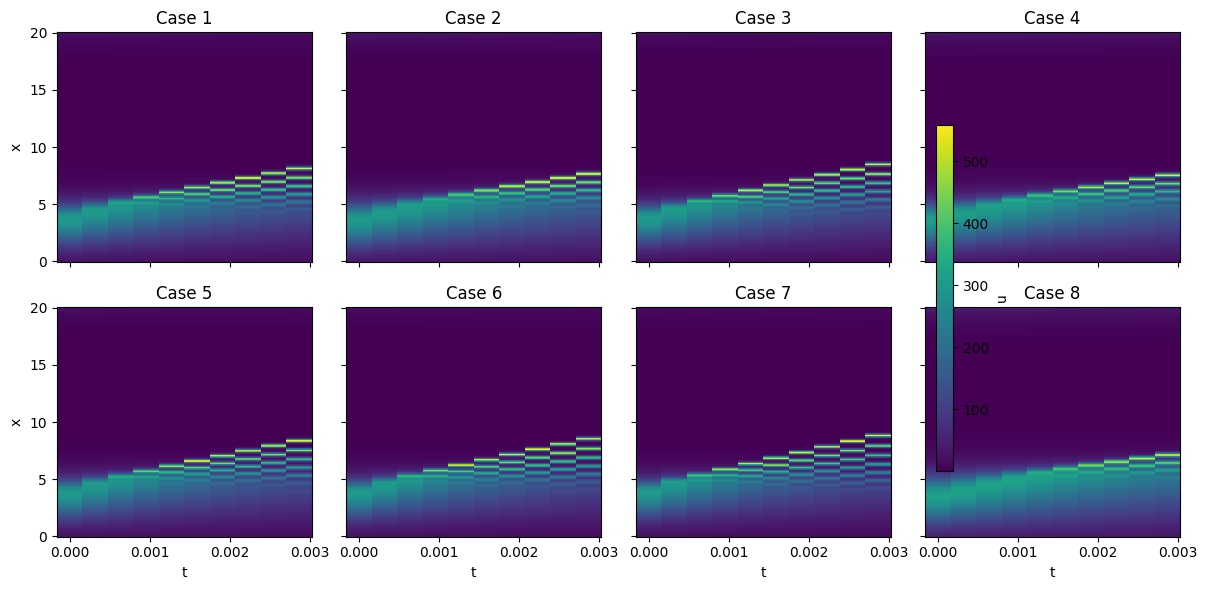

In [34]:
plt.clf()
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for idx, ax in enumerate(axes.ravel()):
    im = ax.pcolormesh(t, x, u_reshape[idx, :, :].T, shading='auto')
    ax.set_title(f'Case {idx+1}')
    if idx % 4 == 0:
        ax.set_ylabel('x')
    if idx >= 4:
        ax.set_xlabel('t')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75, label='u')
plt.tight_layout()


In [ ]:
ux = ps.FiniteDifference(axis=2, order=4)._differentiate(u_reshape, x)
uxx = ps.FiniteDifference(axis=2, order=4)._differentiate(ux, x)
uxxx = ps.FiniteDifference(axis=2, order=4)._differentiate(uxx, x)
uxxxx = ps.FiniteDifference(axis=2, order=4)._differentiate(uxxx, x)

(8, 10, 400)

In [28]:
pde_lib = ps.PDELibrary(
    function_library = ps.PolynomialLibrary(degree=1, include_bias=False),
    derivative_order = 4,
    spatial_grid = x
)
optimizer = ps.STLSQ(threshold=10, alpha=1e-5, normalize_columns=True)


In [29]:
method = ps.FiniteDifference(axis=1, order=2)
model = ps.SINDy(feature_library=pde_lib,optimizer=optimizer, differentiation_method=method)
model.fit(x = case1,x_dot = case1udot, t=t, feature_names=["u"])

# print library
print("PDE SINDy library: ")
print(pde_lib.get_feature_names(["u"]))

# print identified PDE
print("Identified PDE: ")
model.print()

PDE SINDy library: 
['u', 'u_1', 'u_11', 'u_111', 'u_1111', 'uu_1', 'uu_11', 'uu_111', 'uu_1111']
Identified PDE: 
(u)' = 41.637 u + -1495.547 u_1 + -82.597 u_11 + 3.203 u_111 + -0.301 u_1111 + 6.721 uu_1 + 0.038 uu_11 + 0.010 uu_111


In [35]:
model.n_input_features_.shape, case1[:,0,0].shape

AttributeError: 'SINDy' object has no attribute 'n_input_features_'

In [38]:
t.shape

(10,)

In [37]:
# simulate the model
new = model.simulate(case1[:,0,0], t)
plt.plot(t, new, 'r', label='SINDy simulation')
plt.plot(t, case1, 'k--', label='True data')
plt.legend()
plt.xlabel('t')
plt.ylabel('u(t,x)')
plt.title('SINDy simulation vs True data for one case')

ValueError: x shape does not match training shape

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


In [9]:
case1 = u_reshape[0,:,:]
case1=case1.T # shape is now space x time as in tutorial
case1=case1.reshape(400,10,1)
case1.shape

(400, 10, 1)

In [7]:
combined_udot = []
combined_u = []

for i in range(u_reshape.shape[0]):  # 8 cases
    case_i = u_reshape[i, :, :]      # (10, 400) = (time, space)
    combined_u.append(case_i)
    u_dot = ps.FiniteDifference(axis=0, order =4)._differentiate(case_i, t=t)  # d/dt
    combined_udot.append(u_dot)
# Stack to (8, 10, 400) then reshape to (400, 80) = (space, cases*time)
combined_u = np.stack(combined_u, axis=0).transpose(2, 1, 0).reshape(u_reshape.shape[2], -1,1)
combined_udot = np.stack(combined_udot, axis=0).transpose(2, 1, 0).reshape(u_reshape.shape[2], -1,1)


In [8]:
combined_u = np.array(combined_u)
combined_udot = np.array(combined_udot)

In [9]:
# combined_udot = combined_udot.flatten()
# combined_u = combined_u.flatten()

combined_u.shape, combined_udot.shape

((400, 80, 1), (400, 80, 1))

In [78]:
combined_u.shape, combined_udot.shape

((400, 80, 1), (400, 80, 1))

In [14]:
t_comb = np.stack([t]*u_reshape.shape[0])  # repeat t for each case
t_comb = t_comb.flatten()
t_comb = np.logspace(0,1, num=t_comb.shape[0])
t_comb.shape

(80,)

In [10]:
t.shape

(10,)

In [ ]:
model = ps.SINDy(feature_library=pde_lib,optimizer=optimizer, differentiation_method=method)
model.fit(x = case1,x_dot = case1udot, t=t, feature_names=["u"])

# print library
print("PDE SINDy library: ")
print(pde_lib.get_feature_names(["u"]))

# print identified PDE
print("Identified PDE: ")
model.print()

In [12]:
pde_lib = ps.PDELibrary(
    function_library = ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order = 4,
    spatial_grid = x
)
optimizer = ps.STLSQ(threshold=0.10, alpha=1e-5, normalize_columns=True)
method = ps.FiniteDifference(axis=1, order=2)

model1 = ps.SINDy(feature_library=pde_lib,optimizer=optimizer, differentiation_method=method)

In [15]:
model1.fit(x=combined_u, x_dot = combined_udot, t=t_comb)

AttributeError: 'PDELibrary' object has no attribute 'is_uniform'

AttributeError: 'PDELibrary' object has no attribute 'is_uniform'

AttributeError: 'PDELibrary' object has no attribute 'is_uniform'